## Executive Summary

This project explored a datasets from the Centers of Medicare & Medicaid Services (CMS) on nursing home provider information, namely statistical measurements and a binary logistic regression model to predict adverse nursing home outcomes, such as fines and whether a nursing home is cited for abuse, from reported information on medical staffing levels, such as nurses. We discovered that while we could not establish a relationship between medical staffing levels and whether nursing homes receive fines or payment denials from CMS, we discovered that RN staffing levels can reliably predict whether a nursing home is cited for abuse, with around 95% predictive accuracy.

## Introduction

Staffing levels in nursing homes have long been known to be correlative or outright predictive of a variety of outcomes, such as whether residents are victims of abuse (Dicken, 2019), overall low quality of care (Dummit, 2002; Harrington et al., 2016), and even injury to nursing home staff themselves (Trinkoff et al., 2005). These effects are known to exist on political (Blankart et al., 2019), financial (Grabowski et al., 2017), and geographic (Park & Martin, 2018) lines. Adequately addressing the staffing needs of nursing homes in the United States is a major problem with no easy solutions, given the difficulties of working in such settings and the needs of the particular patients who reside within them. 

The purpose of this study was to explore the extent to which certain reported staffing levels from nursing homes themselves to CMS can predict certain adverse outcomes, such as financial penalties, payment denials, and whether any given nursing home is cited for abuse. Addressing these staffing needs in nursing homes must begin long before a staff person walks through any particular set of nursing home doors (Jane Banaszak-Holl et al., 2002) and has implications for how nursing home staff are compensated, suggesting changes needed at the federal level for reimbursement rates for nursing home medical professionals (Konetzka et al., 2006).    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

from sklearn import linear_model
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm

In [2]:
df = pd.read_csv('Provider_Info.csv').set_index('Federal Provider Number')

## EDA and Clean-Up
Below, we take a look at our data and figure out what to do with it.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15491 entries, 45198 to 675792
Data columns (total 85 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Provider Name                                                    15491 non-null  object 
 1   Provider Address                                                 15491 non-null  object 
 2   Provider City                                                    15491 non-null  object 
 3   Provider State                                                   15491 non-null  object 
 4   Provider Zip Code                                                15491 non-null  int64  
 5   Provider Phone Number                                            15491 non-null  int64  
 6   Provider SSA County Code                                         15491 non-null  int64  
 7   Provider County Name                    

We're only interested in a select few of these features. 

In [4]:
cols = [
 'Average Number of Residents Per Day',
 'Provider Resides in Hospital',
 'Cited for Abuse',
 'Most Recent Health Inspection More Than 2 Years Ago',
 'Provider Changed Ownership in Last 12 Months',
 'Reported Nurse Aide Staffing Hours per Resident per Day',
 'Reported LPN Staffing Hours per Resident per Day',
 'Reported RN Staffing Hours per Resident per Day',
 'Reported Licensed Staffing Hours per Resident per Day',
 'Reported Total Nurse Staffing Hours per Resident per Day',
 'Reported Physical Therapist Staffing Hours per Resident Per Day',
 'Number of Facility Reported Incidents',
 'Number of Substantiated Complaints',
 'Number of Fines',
 'Total Amount of Fines in Dollars',
 'Number of Payment Denials',
 'Total Number of Penalties']

In [5]:
df = df[cols]

## Correlation Analysis

We take a look at how features are correlated on an observation-level.

In [6]:
df_continuous_data = df.select_dtypes(include=['int64', 'float64'])
df_continuous_data = df_continuous_data.dropna()

In [7]:
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
df_continuous_data.corr()

,Average Number of Residents Per Day,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties
Average Number of Residents Per Day,1.00,-0.12,-0.00,-0.22,-0.20,-0.20,-0.08,0.10,0.16,0.06,0.05,-0.00,0.05
Reported Nurse Aide Staffing Hours per Resident per Day,-0.12,1.00,0.10,0.32,0.34,0.80,0.13,0.01,-0.15,-0.07,-0.05,-0.04,-0.07
Reported LPN Staffing Hours per Resident per Day,-0.00,0.10,1.00,-0.13,0.50,0.38,0.13,0.01,0.04,-0.01,0.01,-0.00,-0.01
Reported RN Staffing Hours per Resident per Day,-0.22,0.32,-0.13,1.00,0.79,0.69,0.47,-0.05,-0.12,-0.08,-0.06,-0.08,-0.09
Reported Licensed Staffing Hours per Resident per Day,-0.20,0.34,0.50,0.79,1.00,0.84,0.49,-0.03,-0.09,-0.08,-0.04,-0.07,-0.09
Reported Total Nurse Staffing Hours per Resident per Day,-0.20,0.80,0.38,0.69,0.84,1.00,0.39,-0.01,-0.14,-0.09,-0.06,-0.07,-0.10
Reported Physical Therapist Staffing Hours per Resident Per Day,-0.08,0.13,0.13,0.47,0.49,0.39,1.00,-0.04,-0.04,-0.06,-0.04,-0.06,-0.07
Number of Facility Reported Incidents,0.10,0.01,0.01,-0.05,-0.03,-0.01,-0.04,1.00,0.33,0.29,0.17,0.20,0.31
Number of Substantiated Complaints,0.16,-0.15,0.04,-0.12,-0.09,-0.14,-0.04,0.33,1.00,0.38,0.25,0.32,0.43
Number of Fines,0.06,-0.07,-0.01,-0.08,-0.08,-0.09,-0.06,0.29,0.38,1.00,0.51,0.34,0.94


This is hard to read. Let's make a heatmap.

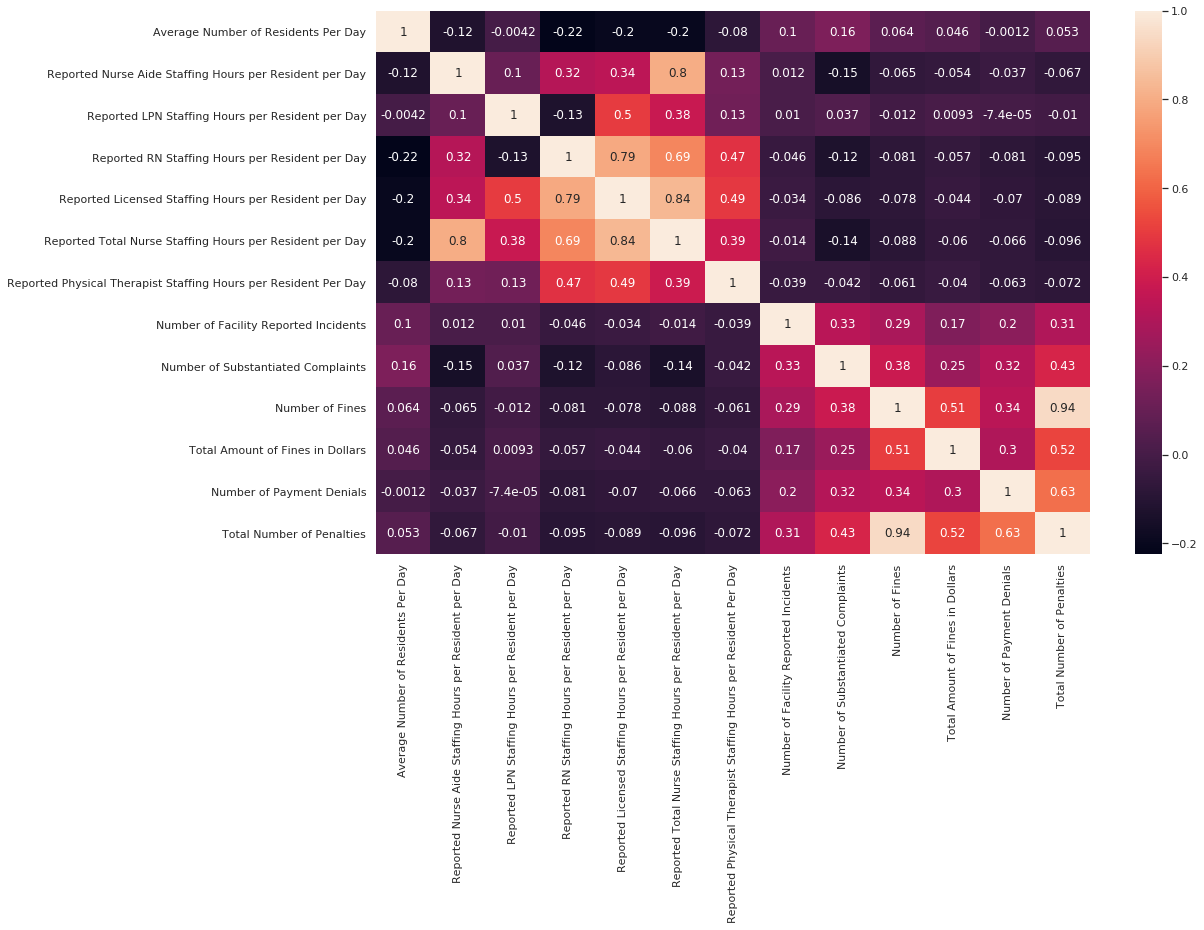

In [9]:
plt.figure(figsize=(16,10))
sns.heatmap(df_continuous_data.corr(), annot=True)
plt.show()

Here we can see that staffing levels appear highly correlated with one another, and financial penalities are correalted with one, but that staffing levels and financial penalties actually appear to be not correlated at all, or negatively correlated. This is both unexpected and unfortunate.

Let's store out heatmap in a variable, then try to make this more clearly visible by filtering for correlation values above 0.5 only.

In [10]:
corr_matrix = df_continuous_data.corr()

In [11]:
corr_matrix[np.abs(corr_matrix) < 0.5] = 0
corr_matrix

,Average Number of Residents Per Day,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties
Average Number of Residents Per Day,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported Nurse Aide Staffing Hours per Resident per Day,0.00,1.00,0.00,0.00,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported LPN Staffing Hours per Resident per Day,0.00,0.00,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported RN Staffing Hours per Resident per Day,0.00,0.00,0.00,1.00,0.79,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported Licensed Staffing Hours per Resident per Day,0.00,0.00,0.50,0.79,1.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported Total Nurse Staffing Hours per Resident per Day,0.00,0.80,0.00,0.69,0.84,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Reported Physical Therapist Staffing Hours per Resident Per Day,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
Number of Facility Reported Incidents,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
Number of Substantiated Complaints,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
Number of Fines,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.51,0.00,0.94


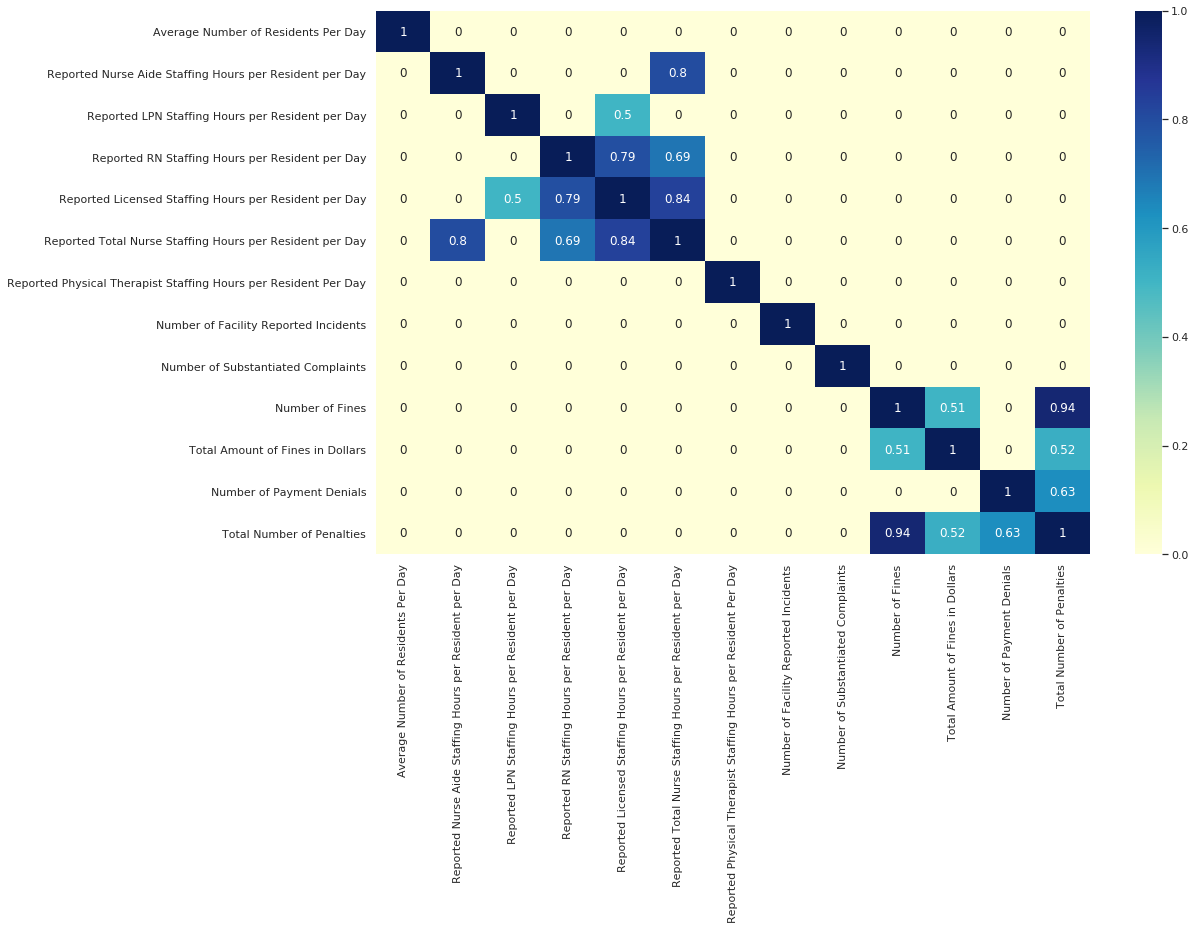

In [12]:
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.show()

## Linear Regression

Indeed, we are unlikely to find anything meaningful here, but let's run a linear regression test to take a further look and confirm or disregard our presumption.

In [13]:
X = df_continuous_data.drop('Total Number of Penalties', axis=1)
y = df_continuous_data['Total Number of Penalties']

In [14]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -1.2212453270876722e-15
Coefficients: 
 [ 1.24896855e-17 -4.21544120e-11 -6.26257952e-11 -6.26268399e-11
  2.04714939e-11  4.21545583e-11  2.16043441e-15  5.17245851e-17
 -4.25805823e-17  1.00000000e+00 -9.89021134e-22  1.00000000e+00]


Such small coefficients likely confirm that there is nothing to see here past what we already suspect. We'll take a look at some other formal statistical measurements on this data.

In [16]:
# with statsmodels
X = sm.add_constant(X) # adding a constant

In [17]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

In [18]:
print_model = model.summary()
print(print_model)

                                OLS Regression Results                               
Dep. Variable:     Total Number of Penalties   R-squared:                       1.000
Model:                                   OLS   Adj. R-squared:                  1.000
Method:                        Least Squares   F-statistic:                 1.310e+25
Date:                       Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                               10:28:27   Log-Likelihood:             3.5677e+05
No. Observations:                      14915   AIC:                        -7.135e+05
Df Residuals:                          14902   BIC:                        -7.134e+05
Df Model:                                 12                                         
Covariance Type:                   nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------

## Logistic Regression

Indeed, there was nothing much to see. However, we are still interested in determining whether we can derive predictions of adverse events in nursing homes from staffing levels. Let's go back to our original data to see what else we can look at.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15491 entries, 45198 to 675792
Data columns (total 17 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Average Number of Residents Per Day                              15428 non-null  float64
 1   Provider Resides in Hospital                                     15491 non-null  bool   
 2   Cited for Abuse                                                  15491 non-null  bool   
 3   Most Recent Health Inspection More Than 2 Years Ago              15491 non-null  bool   
 4   Provider Changed Ownership in Last 12 Months                     15491 non-null  bool   
 5   Reported Nurse Aide Staffing Hours per Resident per Day          14915 non-null  float64
 6   Reported LPN Staffing Hours per Resident per Day                 14915 non-null  float64
 7   Reported RN Staffing Hours per Resident 

Let's use Cited for Abuse as our target attribute, and see if we can predict whether a nursing home is cited for abuse based on staffing levels. Some quick visualizations of the boolean and continuous values ought to give us some insight.

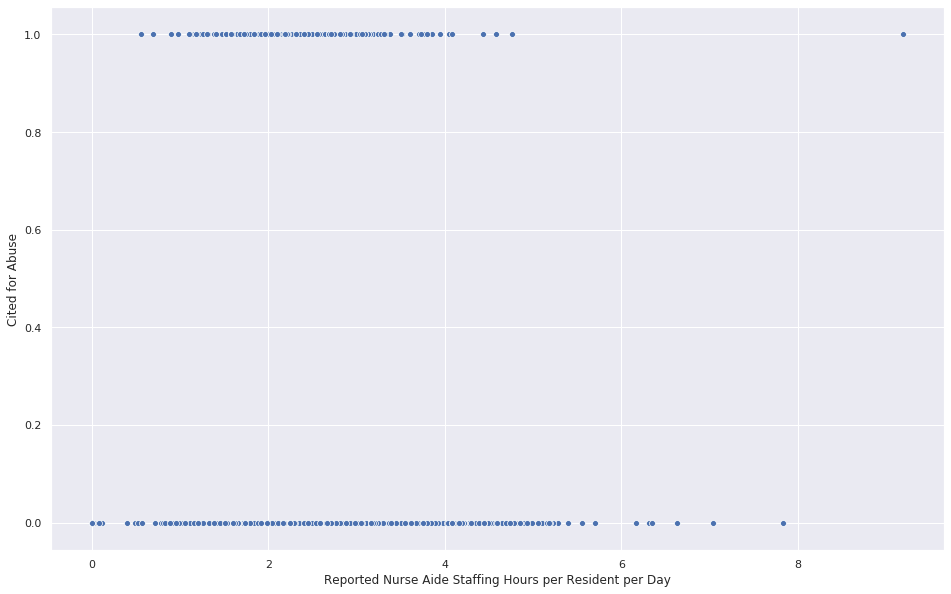

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported Nurse Aide Staffing Hours per Resident per Day", y="Cited for Abuse", data=df)

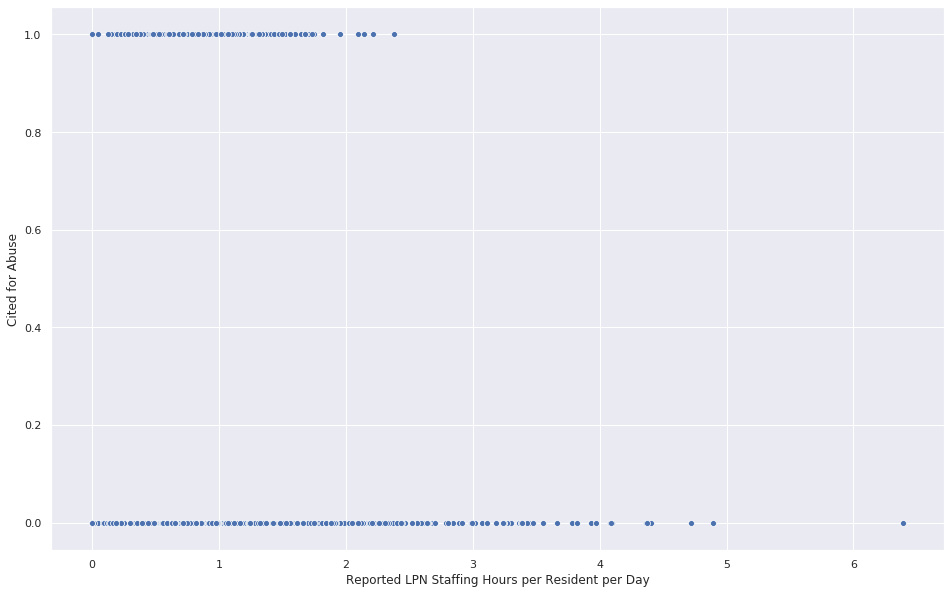

In [22]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported LPN Staffing Hours per Resident per Day", y="Cited for Abuse", data=df)

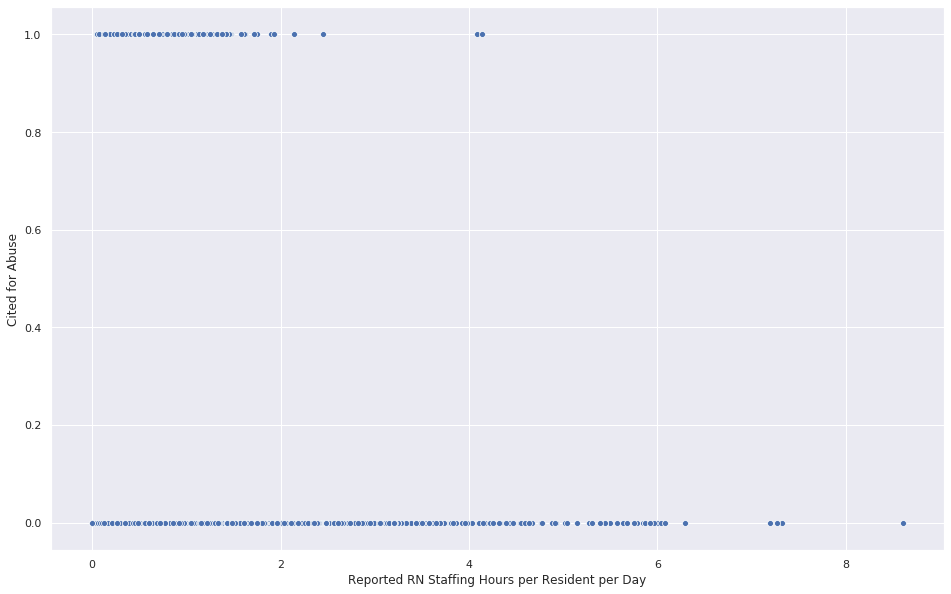

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported RN Staffing Hours per Resident per Day", y="Cited for Abuse", data=df)

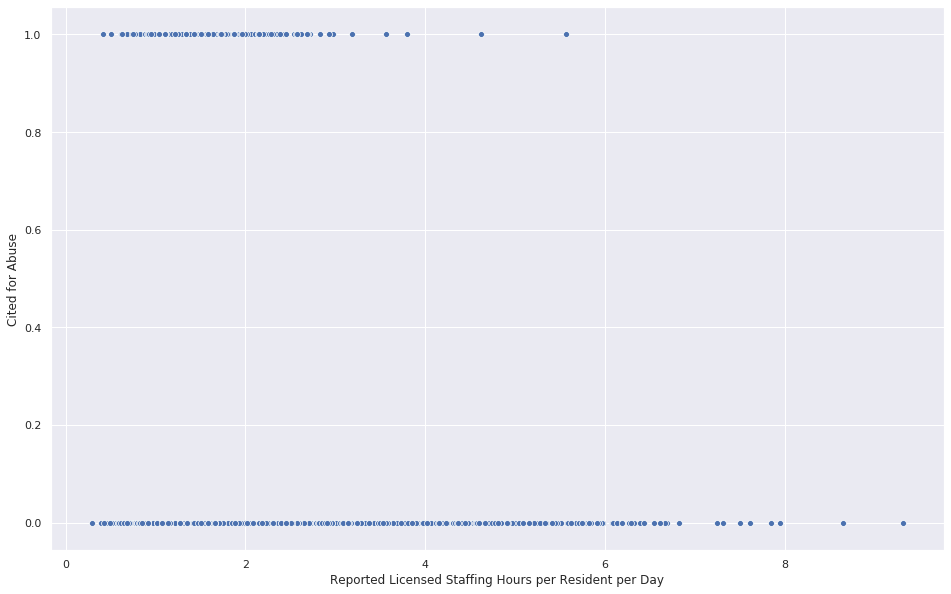

In [24]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported Licensed Staffing Hours per Resident per Day", y="Cited for Abuse", data=df)

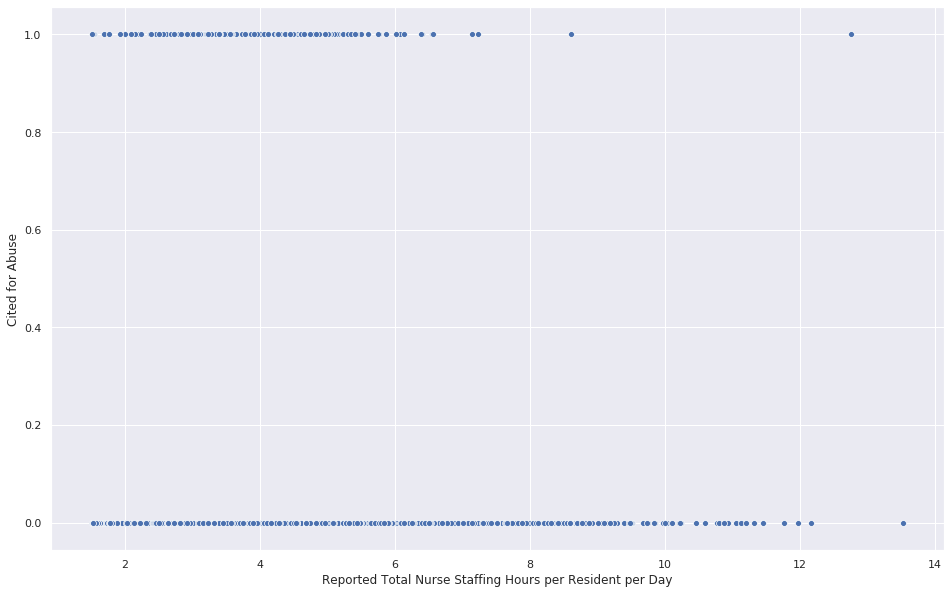

In [25]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported Total Nurse Staffing Hours per Resident per Day", y="Cited for Abuse", data=df)

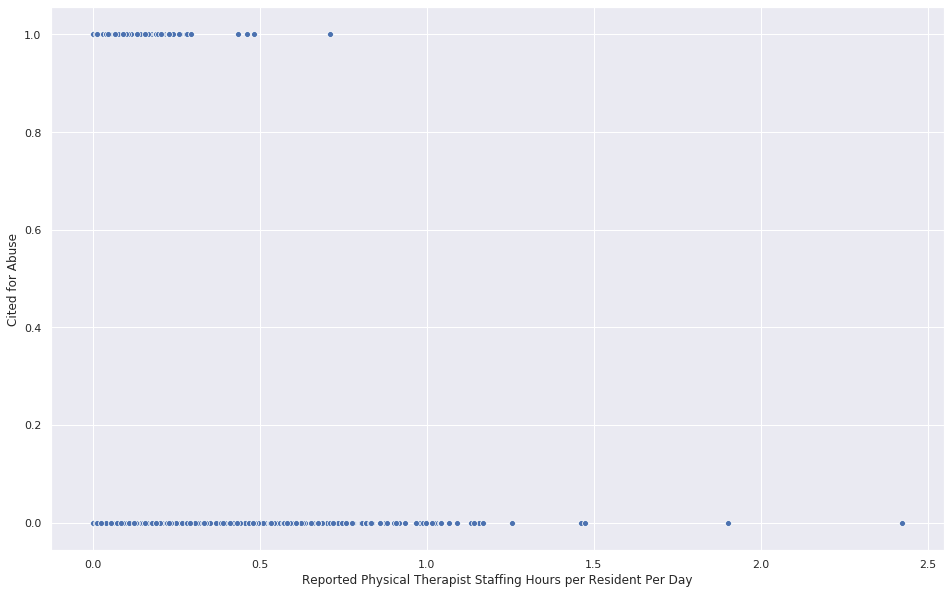

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="Reported Physical Therapist Staffing Hours per Resident Per Day", y="Cited for Abuse", data=df)

Indeed, visual inspection seems to reveal some kind of relationship that we may be able to empirically demonstrate. It seems that RN staffing levels demonstarte the strongest relationship, so let's run logistic regression on it to verify thwether this is predictively relevant for a fact.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df[['Reported RN Staffing Hours per Resident per Day']], df[['Cited for Abuse']], train_size=0.8)

In [46]:
X_train

,Reported RN Staffing Hours per Resident per Day
Federal Provider Number,
525335,0.69
455714,0.36
75031,0.97
255191,0.43
35096,0.95
...,...
365615,0.48
145418,0.17
56195,0.46


In [47]:
X_test

,Reported RN Staffing Hours per Resident per Day
Federal Provider Number,
445224,0.70
676028,0.29
55795,0.65
45419,0.22
155247,0.69
...,...
315343,0.83
395469,0.59
45457,0.25


In [48]:
y_train

,Cited for Abuse
Federal Provider Number,
525335,False
455714,False
75031,False
255191,False
35096,False
...,...
365615,False
145418,False
56195,True


In [49]:
y_test

,Cited for Abuse
Federal Provider Number,
445224,False
676028,False
55795,False
45419,False
155247,False
...,...
315343,False
395469,True
45457,False


In [50]:
model = LogisticRegression()

In [51]:
model.fit(X_train, y_train)

/home/greencrescent/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
model.predict(X_test)

array([False, False, False, ..., False, False, False])

In [53]:
model.score(X_test, y_test)

0.9480388870264834

In [54]:
model.predict_proba(X_test)

array([[0.95269711, 0.04730289],
       [0.94426162, 0.05573838],
       [0.95175809, 0.04824191],
       ...,
       [0.94327245, 0.05672755],
       [0.95217875, 0.04782125],
       [0.94209516, 0.05790484]])

So it turns out that we can predict whether a nursing home will be cited for abuse based on reported number of RN hours per resident per day around 95% of the time. That's crazy!

## Limitations and Conclusion

This is a very brief and slightly informal study of these attributes. More robust analysis and prediction is needed before any of this can be taken as truly valid. We are also not doing anything in the way of normalizing or imputing the data, merely dropping null values in the set, and the dataset itself is fairly small at just under 15,000 observations; this isn't very large for the kind of exercise we're doing here. We also haven't touched any of the other attributes, such as ownership composition or whetehr the nursing home services are rendered in a hospital setting, attributes that may affect whether nursing homes are penalized by CMS or are cited for abuse. We would need to run multinomial logistic regression for more conclusive results, and also fund way to build out our dataset so that it's larger.

That said, these are still important results for determining what's relevant from what's not for answering our questions.

## References

Blankart, C. R., Foster, A. D., & Mor, V. (2019). The effect of political control on financial performance, structure, and outcomes of US nursing homes. Health Services Research, 1. edsbig. https://doi.org/10.1111/1475-6773.13061

Dicken, J. E. (2019). NURSING HOMES: Improved Oversight Needed to Better Protect Residents from Abuse. GAO Reports, 1. pwh.

Dummit, L. A. (2002). Nursing Homes: Quality of Care More Related to Staffing than Spending: GAO-02-431R. GAO Reports, 1.

Grabowski, D. C., Stevenson, D. G., Caudry, D. J., O’Malley, A. J., Green, L. H., Doherty, J. A., & Frank, R. G. (2017). The impact of nursing home pay-for-performance on quality and medicare spending: Results from the nursing home value-based purchasing demonstration. Health Services Research, 4. edsbig. https://doi.org/10.1111/1475-6773.12538

Harrington, C., Schnelle, J. F., McGregor, M., & Simmons, S. F. (2016). The Need for Higher Minimum Staffing Standards in U.S. Nursing Homes. Health Services Insights, 9, 13. edb.

Jane Banaszak-Holl, Whitney B. Berta, Dilys M. Bowman, Joel A. C. Baum, & Will Mitchell. (2002). The Rise of Human Service Chains: Antecedents to Acquisitions and Their Effects on the Quality of Care in US Nursing Homes. Managerial and Decision Economics, 23(4/5), 261. edsjsr.

Konetzka, R. T., Norton, E. C., & Stearns, S. C. (2006). Medicare Payment Changes and Nursing Home Quality: Effects on Long-Stay Residents. International Journal of Health Care Finance and Economics, 6(3), 173. edsjsr. https://doi.org/10.1007/s10754-006-9000-9

Park, Y. J., & Martin, E. G. (2018). Geographic Disparities in Access to Nursing Home Services: Assessing Fiscal Stress and Quality of Care. Health Services Research, 4. edsbig. https://doi.org/10.1111/1475-6773.12801

Trinkoff, A. M., Johantgen, M., Muntaner, C., & Le, R. (2005). Staffing and Worker Injury in Nursing Homes. American Journal of Public Health, 95(7), 1220–1225. pbh.